In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import importlib as imp

import src
import trecs
from trecs.models import ContentFiltering
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement

random_state = np.random.seed(42)

In [20]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [21]:
ratings_df = pd.read_csv('data/ml-100k/u.data', 
                 sep="\t", 
                 names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

## Creating RecommenderSystem on MovieLens 

### Creating Embeddings

In [24]:
from sklearn.decomposition import NMF

binary_ratings_df = ratings_df.drop(columns=['Timestamp'])
binary_ratings_df.loc[binary_ratings_df['Rating'] > 0, 'Rating'] = 1

# turn dataframe into matrix where each movie is a column and each user is a row
binary_ratings_matrix = binary_ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0).to_numpy()

In [25]:
from lightfm.cross_validation import random_train_test_split
from scipy import sparse

# split data into train and test sets
train_interactions, test_interactions = random_train_test_split(sparse.csr_matrix(binary_ratings_matrix), test_percentage=0.2, random_state=random_state)
train_interactions = train_interactions.toarray()
test_interactions = test_interactions.toarray()

c:\Users\Jannik\anaconda3\envs\rsenv\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [33]:
n_attrs=100

nmf = NMF(n_components=n_attrs, solver="mu", max_iter=500)
user_representation = nmf.fit_transform(binary_ratings_matrix)
item_representation = nmf.components_
print(user_representation.shape, item_representation.shape)

c:\Users\Jannik\anaconda3\envs\rsenv\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


(943, 100) (100, 1682)


## Create RS Model

In [39]:
from importlib import reload
import wrapper
from wrapper.models.bubble import BubbleBurster
from trecs.components import Users
from src.utils import get_topic_clusters
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric
reload(wrapper.metrics.evaluation_metrics)
reload(wrapper.models.bubble)
from wrapper.models.bubble import BubbleBurster
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric

In [31]:
users = Users(size=(943,100), repeat_interactions=False)

num_topics = None
item_topics = get_topic_clusters(binary_ratings_matrix, n_attrs=n_attrs, max_iter=200, nmf_solver="mu")
user_topic_history = None
item_count = None

c:\Users\Jannik\anaconda3\envs\rsenv\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [40]:
recsys = BubbleBurster(
    item_topics=item_topics,
    user_representation=user_representation,
    item_representation=item_representation,
    actual_user_representation=users,
    record_base_state=True,
)

user_pairs = [(u_idx, v_idx) for u_idx in range(recsys.num_users) for v_idx in range(recsys.num_users)]

mse = MSEMeasurement(diagnostics=True)

recsys.add_metrics(InteractionMeasurement(),
                   mse,
                   InteractionSpread(),
                   SerendipityMetric(),
                   DiversityMetric(),
                   NoveltyMetric(),
                   RecSimilarity(pairs=user_pairs),
                   )

[]


IndexError: index 0 is out of bounds for axis 1 with size 0

In [ ]:
print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {recsys.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {recsys.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 100)
- A randomly generated matrix of items of dimension (100, 1682)


## Simulation

In [ ]:
recsys.startup_and_train(timesteps=100)

100%|██████████| 100/100 [15:00<00:00,  9.01s/it]


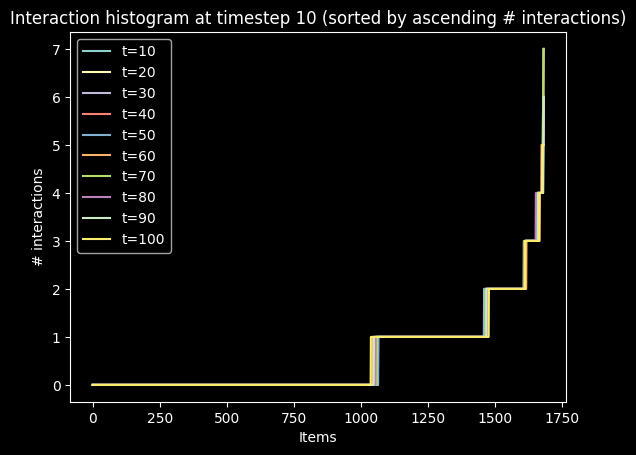

In [ ]:
# for every 10 timesteps plot line in different color
for i in range(10, 101, 10):
    plt.plot(np.arange(recsys.num_items), sorted(measurements['interaction_histogram'][i]), label=f't={i}')

plt.legend()
plt.title("Interaction histogram at timestep %d (sorted by ascending # interactions)" % timestep)
plt.xlabel("Items")
plt.ylabel("# interactions")
plt.show()

In [ ]:
measurements = recsys.get_measurements()
pd.DataFrame(measurements)
#plot time series of mse over timesteps
# plt.plot(measurements['mse'])

,interaction_histogram,mse,interaction_spread,rec_similarity,timesteps
0,None,0.077926,NaN,NaN,0
1,"[2.0, 4.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...",0.077926,-940.0,0.004164,1
2,"[1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 3.0, ...",0.077926,0.5,0.004155,2
3,"[5.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0.077926,-0.5,0.004157,3
4,"[1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0.077926,-0.5,0.004206,4
...,...,...,...,...,...
96,"[0.0, 4.0, 0.0, 1.0, 2.0, 0.0, 4.0, 1.0, 2.0, ...",0.077926,0.0,0.004172,96
97,"[2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, ...",0.077926,0.0,0.004226,97
98,"[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, ...",0.077926,0.0,0.004173,98
99,"[1.0, 1.0, 2.0, 3.0, 3.0, 1.0, 0.0, 1.0, 2.0, ...",0.077926,1.5,0.004217,99


In [ ]:
# print majority / minority outcome stats
def majority_minority_outcomes(metric, split_index):
    split_indices = [split_index]

        
    maj_mean = metric.last_observation[:split_index].mean()
    maj_std = metric.last_observation[:split_index].std()

    min_mean = metric.last_observation[split_index:].mean()
    min_std = metric.last_observation[split_index:].std()

    print("Majority group statistics: ", maj_mean, "(mean), ", maj_std, "(std)")
    print("Minority group statistics: ", min_mean, "(mean), ", min_std, "(std)")
    print()
    
    metric.hist(split_indices)

In [ ]:
majority_minority_outcomes(mse, )